In [1]:
from pathlib import Path
from datatree import DataTree
import datatree
import xarray as xr
import pandas as pd
import numpy as np
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd
import matplotlib.pyplot as plt

import valenspy as vp
from valenspy.cf_checks import cf_status, is_cf_compliant

# Import data

We will start by loading in the data from all 4 simulations. This data will be grouped in a DataTree structure, as they are defined on different grids but we want to perform the same calculations on all of them. To prevent the notebook from running to long, we will only use data from the year 2021.

In [2]:
levels = ["level01", "level02", "level03", "level04"]
data_tree = {}
for level in levels:
    print(level)
    files = list(Path(f"/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc45263_wout/DYDOCASE/export/long/{level}/pr/output/").rglob('*2021_??.nc'))
    ds = xr.open_mfdataset(files, combine='by_coords', chunks="auto")
    data_tree[level] = ds

level01
level02
level03
level04


In [3]:
dt = DataTree.from_dict(data_tree)
dt

DataTree('None', parent=None)
├── DataTree('level01')
│       Dimensions:             (time: 8760, y: 251, x: 251, bnds: 2)
│       Coordinates:
│         * x                   (x) float64 2kB -3.125e+06 -3.1e+06 ... 3.125e+06
│         * y                   (y) float64 2kB 2.974e+06 2.999e+06 ... 9.224e+06
│         * time                (time) datetime64[ns] 70kB 2021-01-01T01:00:00 ... 20...
│           time_bnds           (time, bnds) datetime64[ns] 140kB dask.array<chunksize=(744, 2), meta=np.ndarray>
│           lon                 (y, x) float64 504kB dask.array<chunksize=(251, 251), meta=np.ndarray>
│           lat                 (y, x) float64 504kB dask.array<chunksize=(251, 251), meta=np.ndarray>
│           lambert_projection  int64 8B 0
│       Dimensions without coordinates: bnds
│       Data variables:
│           pr                  (time, y, x) float64 4GB dask.array<chunksize=(528, 178, 178), meta=np.ndarray>
│       Attributes:
│           Conventions:  CF-1.11
│           title:        Climate model data
│           institution:  Ghent University
│           source:       ALARO-1 (CY43T2) - SURFEX v8.0
│           history:      2024-04-24 14:50:48.059273 Python
│           references:   
│           comments:     
├── DataTree('level02')
│       Dimensions:             (time: 8760, y: 499, x: 499, bnds: 2)
│       Coordinates:
│         * x                   (x) float64 4kB -3.112e+06 -3.1e+06 ... 3.112e+06
│         * y                   (y) float64 4kB 2.986e+06 2.999e+06 ... 9.211e+06
│         * time                (time) datetime64[ns] 70kB 2021-01-01T01:00:00 ... 20...
│           time_bnds           (time, bnds) datetime64[ns] 140kB dask.array<chunksize=(744, 2), meta=np.ndarray>
│           lon                 (y, x) float64 2MB dask.array<chunksize=(499, 499), meta=np.ndarray>
│           lat                 (y, x) float64 2MB dask.array<chunksize=(499, 499), meta=np.ndarray>
│           lambert_projection  int64 8B 0
│       Dimensions without coordinates: bnds
│       Data variables:
│           pr                  (time, y, x) float64 17GB dask.array<chunksize=(334, 224, 224), meta=np.ndarray>
│       Attributes:
│           Conventions:  CF-1.11
│           title:        Climate model data
│           institution:  Ghent University
│           source:       ALARO-1 (CY43T2) - SURFEX v8.0
│           history:      2024-04-24 14:53:43.424914 Python
│           references:   
│           comments:     
├── DataTree('level03')
│       Dimensions:             (time: 8760, y: 421, x: 421, bnds: 2)
│       Coordinates:
│         * x                   (x) float64 3kB -8.4e+05 -8.36e+05 ... 8.36e+05 8.4e+05
│         * y                   (y) float64 3kB 5.572e+06 5.576e+06 ... 7.252e+06
│         * time                (time) datetime64[ns] 70kB 2021-01-01T01:00:00 ... 20...
│           time_bnds           (time, bnds) datetime64[ns] 140kB dask.array<chunksize=(744, 2), meta=np.ndarray>
│           lon                 (y, x) float64 1MB dask.array<chunksize=(421, 421), meta=np.ndarray>
│           lat                 (y, x) float64 1MB dask.array<chunksize=(421, 421), meta=np.ndarray>
│           lambert_projection  int64 8B 0
│       Dimensions without coordinates: bnds
│       Data variables:
│           pr                  (time, y, x) float64 12GB dask.array<chunksize=(374, 211, 211), meta=np.ndarray>
│       Attributes:
│           Conventions:  CF-1.11
│           title:        Climate model data
│           institution:  Ghent University
│           source:       ALARO-1 (CY43T2) - SURFEX v8.0
│           history:      2024-04-25 08:02:05.386291 Python
│           references:   
│           comments:     
└── DataTree('level04')
        Dimensions:             (time: 8760, y: 421, x: 421, bnds: 2)
        Coordinates:
          * x                   (x) float64 3kB -2.73e+05 -2.717e+05 ... 2.73e+05
          * y                   (y) float64 3kB 6.098e+06 6.099e+06 ... 6.644e+06
          * time

Secondly, we will load in a shapefile which contains the administrative boundaries of all countries in the world. We select Belgium from this list and plot it.

<Axes: >

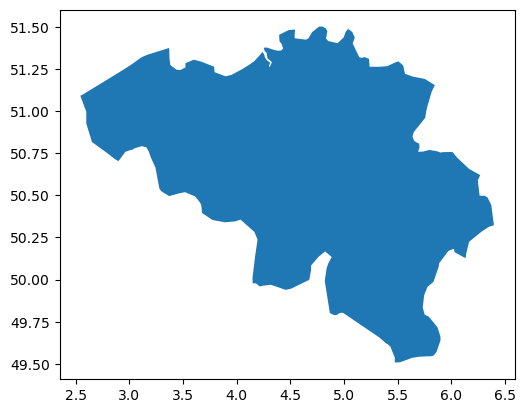

In [4]:
countries = gpd.read_file("../src/valenspy/datafiles/world-administrative-boundaries.shp")
belgium_shape = countries[countries["name"] == "Belgium"].geometry
belgium_shape.plot()

# Calculate daily cycle

In [9]:
def daily_cycle(ds):

    """
    This function calculate the daily cycle of an xarray DataSet
    by grouping the data per hour of the day and calculating the 
    mean value at each hour.
    """

    ds_daily_cycle = ds.groupby('time.hour').mean('time')
    return ds_daily_cycle

def plot_daily_cycle(ds, var):

    """
    This function plots the daily cycle in function of the hour
    of the day. 
    """

    ds[var].plot.line(x='hour')
    return ds

def clip_shapes(ds, shapes, shape_crs=ccrs.PlateCarree(), drop=True):

    """
    This function cuts out the values which are contained by a given
    shape. 
    """

    ds_clipped = ds.rio.clip(shapes, shape_crs, drop=drop)
    return ds_clipped

In [10]:
dt_clipped = dt.map_over_subtree(clip_shapes, list(belgium_shape))
dt_areal_mean = dt_clipped.mean(dim=["x", "y"], keep_attrs=True)
dt_daily_cycle = dt_areal_mean.map_over_subtree(daily_cycle)

In [11]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    dt_daily_cycle_computed = dt_daily_cycle.compute()

[########################################] | 100% Completed | 32.73 s
[########################################] | 100% Completed | 209.80 s
[########################################] | 100% Completed | 49.45 s
[########################################] | 100% Completed | 40.47 s


DataTree('None', parent=None)
├── DataTree('level01')
│       Dimensions:             (hour: 24)
│       Coordinates:
│           lambert_projection  int64 8B 0
│         * hour                (hour) int64 192B 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23
│       Data variables:
│           pr                  (hour) float64 192B 0.133 0.1378 ... 0.1361 0.1325
│       Attributes:
│           Conventions:  CF-1.11
│           title:        Climate model data
│           institution:  Ghent University
│           source:       ALARO-1 (CY43T2) - SURFEX v8.0
│           history:      2024-04-24 14:50:48.059273 Python
│           references:   
│           comments:     
├── DataTree('level02')
│       Dimensions:             (hour: 24)
│       Coordinates:
│           lambert_projection  int64 8B 0
│         * hour                (hour) int64 192B 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23
│       Data variables:
│           pr                  (hour) float64 192B 0.09557 0.09966 ... 0.1121 0.0994
│       Attributes:
│           Conventions:  CF-1.11
│           title:        Climate model data
│           institution:  Ghent University
│           source:       ALARO-1 (CY43T2) - SURFEX v8.0
│           history:      2024-04-24 14:53:43.424914 Python
│           references:   
│           comments:     
├── DataTree('level03')
│       Dimensions:             (hour: 24)
│       Coordinates:
│           lambert_projection  int64 8B 0
│         * hour                (hour) int64 192B 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23
│       Data variables:
│           pr                  (hour) float64 192B 0.08805 0.08836 ... 0.1081 0.09711
│       Attributes:
│           Conventions:  CF-1.11
│           title:        Climate model data
│           institution:  Ghent University
│           source:       ALARO-1 (CY43T2) - SURFEX v8.0
│           history:      2024-04-25 08:02:05.386291 Python
│           references:   
│           comments:     
└── DataTree('level04')
        Dimensions:             (hour: 24)
        Coordinates:
            lambert_projection  int64 8B 0
          * hour                (hour) int64 192B 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23
        Data variables:
            pr                  (hour) float64 192B 0.09136 0.08956 ... 0.1098 0.1009
        Attributes:
            Conventions:  CF-1.11
            title:        Climate model data
            institution:  Ghent University
            source:       ALARO-1 (CY43T2) - SURFEX v8.0
            history:      2024-04-25 08:37:12.509404 Python
            references:   
            comments:

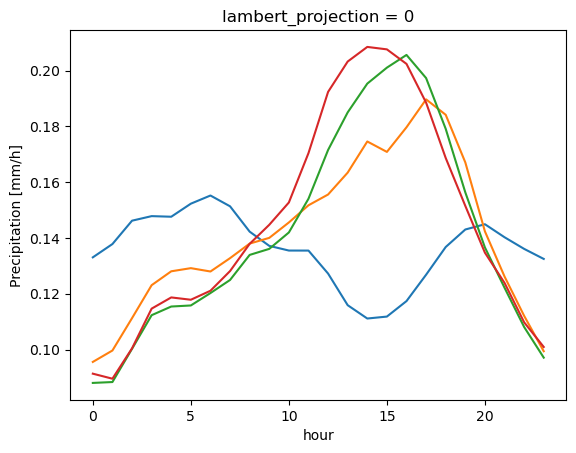

In [12]:
fig, ax = plt.subplots()
dt_daily_cycle_computed.map_over_subtree(plot_daily_cycle, "pr")